In [1]:
import datetime
from datetime import date
import pandas as pd
import scipy.stats as stat
from scipy.stats import norm
from scipy.stats import alpha
from scipy.stats import lognorm
from scipy.stats import weibull_min
from scipy.stats import exponweib
from scipy.optimize import minimize
import copy

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\Jérémie\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['copy', 'norm']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
dates = pd.read_csv('E:/eDocuments/obso/dates.csv', sep=';')

In [4]:
ventes = pd.read_csv('E:/eDocuments/obso/vente_tout_constructeurs.csv', sep=';')

In [5]:
dates[:21]

,marque,modèle,date,date_fin,pred,succ,différence,résultat
0,Apple,iPhone SE 2020,01/04/2020,NaN,iPhone SE,NaN,NaN,NaN
1,Apple,iPhone 11,01/09/2019,NaN,iPhone Xr,NaN,NaN,NaN
2,Apple,iPhone 11 Pro,01/09/2019,NaN,iPhone Xs,NaN,NaN,NaN
3,Apple,iPhone 11 Pro Max,01/09/2019,NaN,iPhone Xs Max,NaN,NaN,NaN
4,Apple,iPhone Xr,01/09/2018,01/09/2019,iPhone X,iPhone 11,12.0,NaN
5,Apple,iPhone Xs,01/09/2018,01/09/2019,iPhone X,iPhone 11 Pro,12.0,NaN
6,Apple,iPhone Xs Max,01/09/2018,01/09/2019,iPhone X,iPhone 11 Pro Max,12.0,NaN
7,Apple,iPhone X,01/09/2017,01/09/2018,NaN,iPhone Xr,12.0,NaN
8,Apple,iPhone 8,01/09/2017,NaN,iPhone 7,NaN,NaN,NaN
9,Apple,iPhone 8 Plus,01/09/2017,NaN,iPhone 7 Plus,NaN,NaN,NaN


In [6]:
ventes.head()

,Trimestre,Quarter,Samsung,Huawei,Apple,Xiaomi,Oppo,Vivo,Sony
0,30/09/2007,Q3,NaN,NaN,"1,12",NaN,NaN,NaN,NaN
1,31/12/2007,Q4,NaN,NaN,"2,32",NaN,NaN,NaN,NaN
2,31/03/2008,Q1,NaN,NaN,"1,7",NaN,NaN,NaN,NaN
3,30/06/2008,Q2,NaN,NaN,"0,72",NaN,NaN,NaN,NaN
4,30/09/2008,Q3,NaN,NaN,"6,9",NaN,NaN,NaN,NaN


In [7]:
diff = dates["différence"]
#dates["marque"] = [m.rstrip() for m in dates["marque"]] # nettoyage des clefs

In [8]:
medianes = dates.groupby(["marque"]).median()
medianes

,différence,résultat
marque,,
Apple,12.0,NaN
Google,12.0,NaN
Huawei,10.5,NaN
Motorola,10.0,NaN
OnePlus,6.0,NaN
Oppo,6.0,NaN
Samsung,11.0,NaN
Sony,8.0,NaN
Vivo,6.0,NaN


In [9]:
# remplissage median des différences allons-y franchement quoi
for i,diff in enumerate(dates["différence"]):
    if diff != diff: # NaN test
        dates["différence"][i] = medianes["différence"][dates["marque"][i]]

C:\Users\Jérémie\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [10]:
for i,debut in enumerate(dates["date"]):
    if not(isinstance(debut, datetime.date)): 
        if debut != debut:
            continue
        if debut.find("/")<0:
            continue
        dates["date"][i] = datetime.date(int(debut.split("/")[2]),int(debut.split("/")[1]),int(debut.split("/")[0]))
    if dates["date_fin"][i] != dates["date_fin"][i]: # NaN test
        #dates["date_fin"][i] = dates["date"][i] + datetime.date(int(medianes["différence"][dates["marque"][i]]//12),int(medianes["différence"][dates["marque"][i]]%12+1),int((medianes["différence"][dates["marque"][i]]%int(medianes["différence"][dates["marque"][i]]))*60+1))
        dates["date_fin"][i] = dates["date"][i] + datetime.timedelta(days=medianes["différence"][dates["marque"][i]]*30)
    if not(isinstance(dates["date_fin"][i], datetime.date)):
        if dates["date_fin"][i].find("/")<0:
            continue
        dates["date_fin"][i] = datetime.date(int(dates["date_fin"][i].split("/")[2]),int(dates["date_fin"][i].split("/")[1]),int(dates["date_fin"][i].split("/")[0]))

C:\Users\Jérémie\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\Jérémie\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Jérémie\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [11]:
dates[:21]

,marque,modèle,date,date_fin,pred,succ,différence,résultat
0,Apple,iPhone SE 2020,2020-04-01,2021-03-27,iPhone SE,NaN,12.0,NaN
1,Apple,iPhone 11,2019-09-01,2020-08-26,iPhone Xr,NaN,12.0,NaN
2,Apple,iPhone 11 Pro,2019-09-01,2020-08-26,iPhone Xs,NaN,12.0,NaN
3,Apple,iPhone 11 Pro Max,2019-09-01,2020-08-26,iPhone Xs Max,NaN,12.0,NaN
4,Apple,iPhone Xr,2018-09-01,2019-09-01,iPhone X,iPhone 11,12.0,NaN
5,Apple,iPhone Xs,2018-09-01,2019-09-01,iPhone X,iPhone 11 Pro,12.0,NaN
6,Apple,iPhone Xs Max,2018-09-01,2019-09-01,iPhone X,iPhone 11 Pro Max,12.0,NaN
7,Apple,iPhone X,2017-09-01,2018-09-01,NaN,iPhone Xr,12.0,NaN
8,Apple,iPhone 8,2017-09-01,2018-08-27,iPhone 7,NaN,12.0,NaN
9,Apple,iPhone 8 Plus,2017-09-01,2018-08-27,iPhone 7 Plus,NaN,12.0,NaN


In [12]:
# "select * from dates where marque = .." manuel
touteslesmarques = ["Apple", "Samsung", "OnePlus", "Xiaomi", "Oppo", "Vivo", "Sony", "Huawei", "Google", "Motorola"]
for marque in touteslesmarques:
    globals()["debut_"+marque] = []
    globals()["fin_"+marque] = []
    globals()["modele_"+marque] = []
    for i,d in enumerate(dates["date"]):
        if dates["marque"][i] == marque:
            globals()["debut_"+marque].append(d)
            globals()["fin_"+marque].append(dates["date_fin"][i])
            globals()["modele_"+marque].append(dates["modèle"][i])

In [13]:
debut_Apple

[datetime.date(2020, 4, 1),
 datetime.date(2019, 9, 1),
 datetime.date(2019, 9, 1),
 datetime.date(2019, 9, 1),
 datetime.date(2018, 9, 1),
 datetime.date(2018, 9, 1),
 datetime.date(2018, 9, 1),
 datetime.date(2017, 9, 1),
 datetime.date(2017, 9, 1),
 datetime.date(2017, 9, 1),
 datetime.date(2016, 9, 1),
 datetime.date(2016, 9, 1),
 datetime.date(2016, 3, 1),
 datetime.date(2015, 9, 1),
 datetime.date(2015, 9, 1),
 datetime.date(2014, 9, 1),
 datetime.date(2014, 9, 1),
 datetime.date(2013, 9, 1),
 datetime.date(2013, 9, 1),
 datetime.date(2012, 9, 1),
 datetime.date(2011, 10, 1),
 datetime.date(2010, 6, 1)]

$\forall x > 0, \forall a> 0, f(x,a) = \frac{1}{x^2 \Phi(a) \sqrt{2 \pi}} \times \exp(-\frac{1}{2}(a-1/x)^2)$ avec $\Phi$ la loi normale $f$ est une fonction de densité de probabilité.

In [14]:
trimestre = [datetime.date(int(d.split("/")[2]),int(d.split("/")[1]),int(d.split("/")[0])).toordinal() for d in ventes["Trimestre"]]

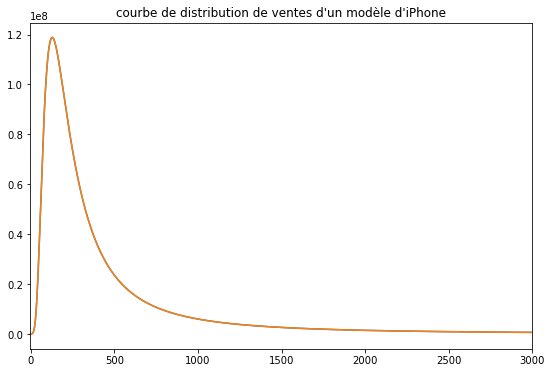

In [69]:
def distrib(x,debut,scale,var):
    if scale < 0 or var < 0:
        return [100000000000]*len(x)
    else:
        #return stat.norm.pdf(x,debut+scale/2,scale/6)*var#*scale
        #return lognorm.pdf(x,2, debut, scale/6)*var#*scale
        return alpha.pdf(x, 0.8, debut-scale/10, scale/1.7)*var*scale if scale and var > 0 else [0]*len(x)
        #return weibull_min.pdf(x,1.1,0) 
        #return exponweib.pdf(x,1.5,1)

x = np.arange(-10, 10000, 1)
y = distrib(x,0,60,70000000)
y2 = distrib(x,0,600,70000000)
fig, ax = plt.subplots(figsize=(9,6))


ax.plot(x,y)
ax.plot(x,y2)
ax.set_xlim([-3,3000])
ax.set_title("courbe de distribution de ventes d'un modèle d'iPhone")

plt.show()

# fonction objectif

In [16]:
def mini_obj(X, args, ventes_totales, abscisses):
    #print(X)
    cumul = [0 for i in range(len(abscisses))]
    for i in range(int(len(X)/2)):
        largeur, hauteur = X[i*2], X[i*2+1]
        date, ponderation = args[i*2], args[i*2+1]
        y=distrib(abscisses, date, largeur, hauteur)
        cumul = [cumul[i]+x*ponderation for i,x in enumerate(y)]           
    return cumul

def montre_solution(X, args, ventes_totales, abscisses):
    cumul = [0 for i in range(len(abscisses))]
    fig, ax = plt.subplots(figsize=(9,6))
    for i in range(int(len(X)/2)):
        largeur, hauteur = X[i*2], X[i*2+1]
        date, ponderation = args[i*2], args[i*2+1]
        y=distrib(abscisses, date, largeur, hauteur)
        cumul = [cumul[i]+x*ponderation for i,x in enumerate(y)]           
        ax.plot(abscisses, y, label=str(i+1)+" (x"+str(ponderation)+")"+" largeur : "+str(round(largeur,1))+" hauteur : "+str(round(hauteur,1)))    
    ax.plot(abscisses, cumul, 'k', label="ventes cumulees")
    ax.plot(abscisses, ventes_totales, 'b', label="ventes totales")
    ax.legend(bbox_to_anchor=(1.5, 1))
    plt.show()

def objectif(X, args, ventes_totales, abscisses):
    ventes_cumulees = mini_obj(X, args, ventes_totales, abscisses)
    result = float(abs(sum([abs(x-y) for x,y in zip(ventes_cumulees, ventes_totales)])))
    #print(result)
    return result

In [17]:
#objectif([5,15,5,1,1,2], [1,1,2,4,3,1], [0,0,27,24,20,15,11,8,6,5], [0,1,2,3,4,5,6,7,8,9])
objectif([3.50427996,15,5,1,1,2], [1,1,2,4,3,1], [0,0,27,24,30,15,11,8,6,5], [0,1,2,3,4,5,6,7,8,9])

63.0442175948548

In [18]:
def obj_test(X):
    return objectif(X, [1,2,5,1,3,1], [0,0,27,24,20,15,30,10,6,5], [0,1,2,3,4,5,6,7,8,9])

In [19]:
reponse = minimize(obj_test, [5.0,15.0,5.0,1.0,1.0,2.0], method='Powell')

In [20]:
reponse.x

array([ 6.07127678,  8.73423924,  2.45304407, 18.69167704,  6.70733451,
        3.89928691])

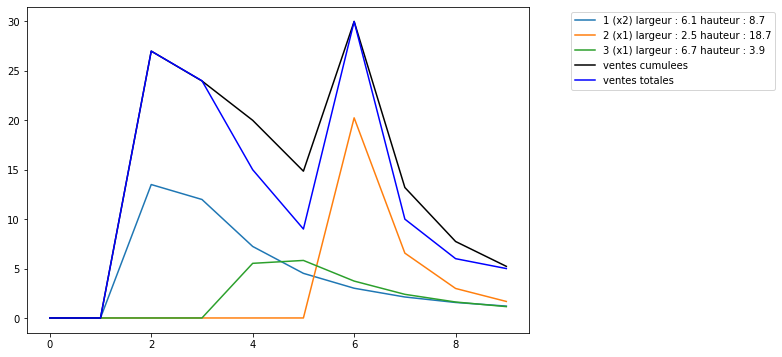

In [21]:
montre_solution(reponse.x, [1,2,5,1,3,1], [0,0,27,24,15,9,30,10,6,5], [0,1,2,3,4,5,6,7,8,9])

In [30]:
args = []
bnds = (((60, 600),(1000000, 60000000))*8)
print(bnds)

((1000000, 200000000), (30, 600), (1000000, 200000000), (30, 600), (1000000, 200000000), (30, 600), (1000000, 200000000), (30, 600), (1000000, 200000000), (30, 600), (1000000, 200000000), (30, 600), (1000000, 200000000), (30, 600), (1000000, 200000000), (30, 600))


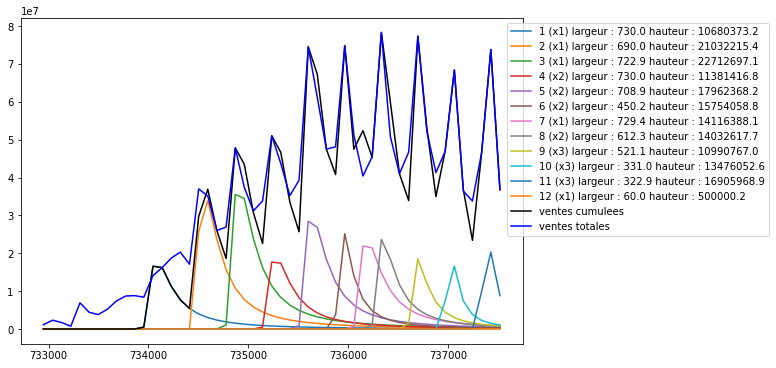

215989343.3638314


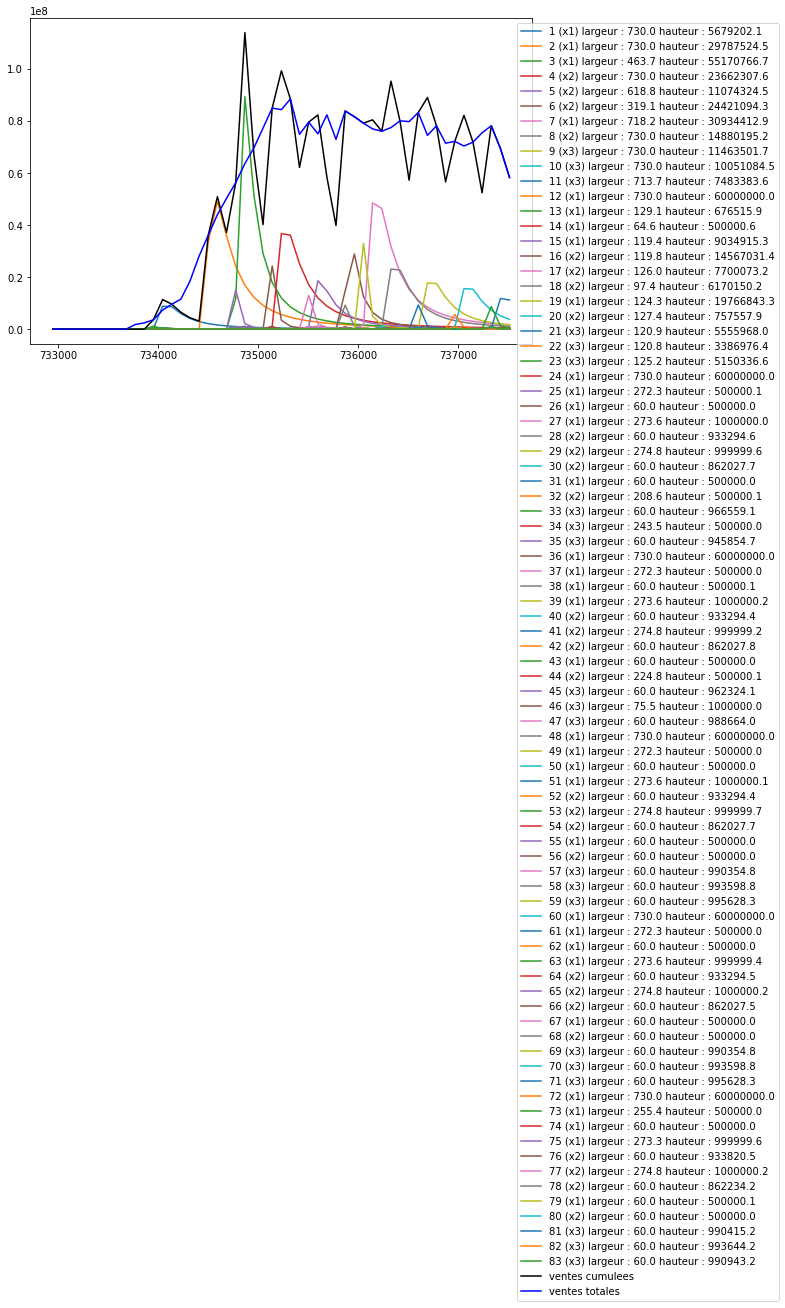

362632552.35695463


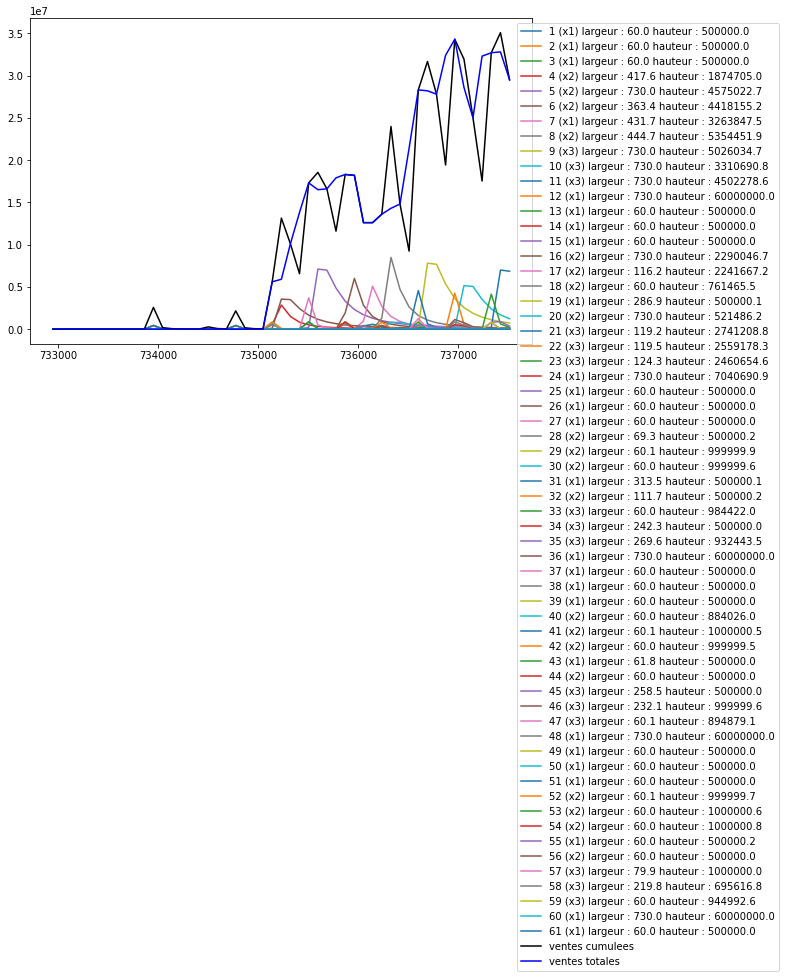

87132817.43930551


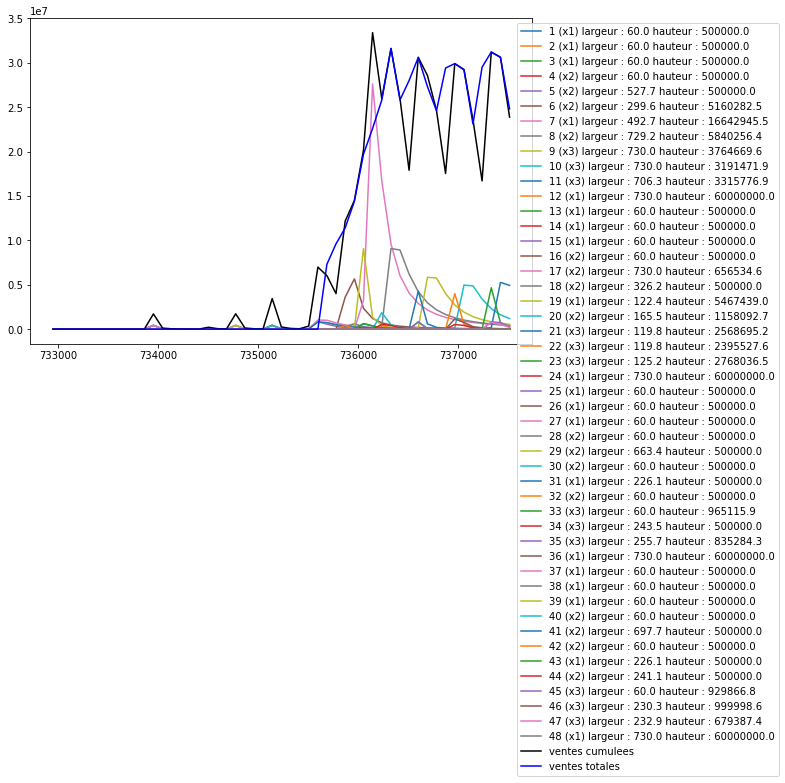

72088789.52427372


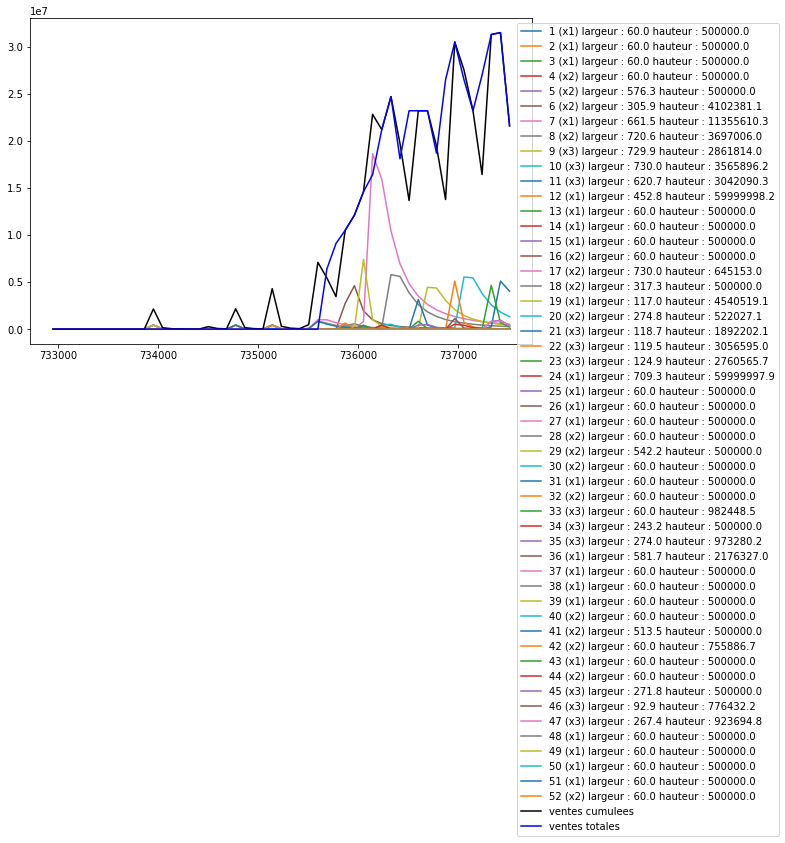

66748264.087412566


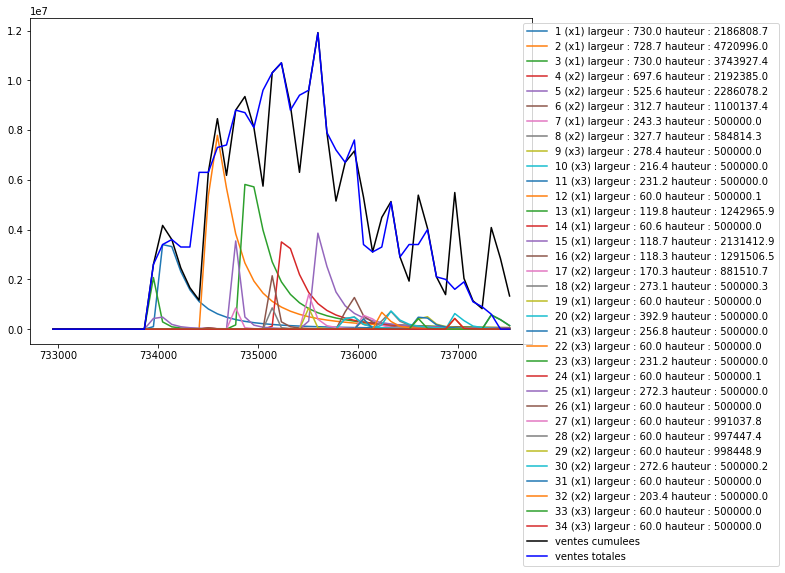

40114016.18779289


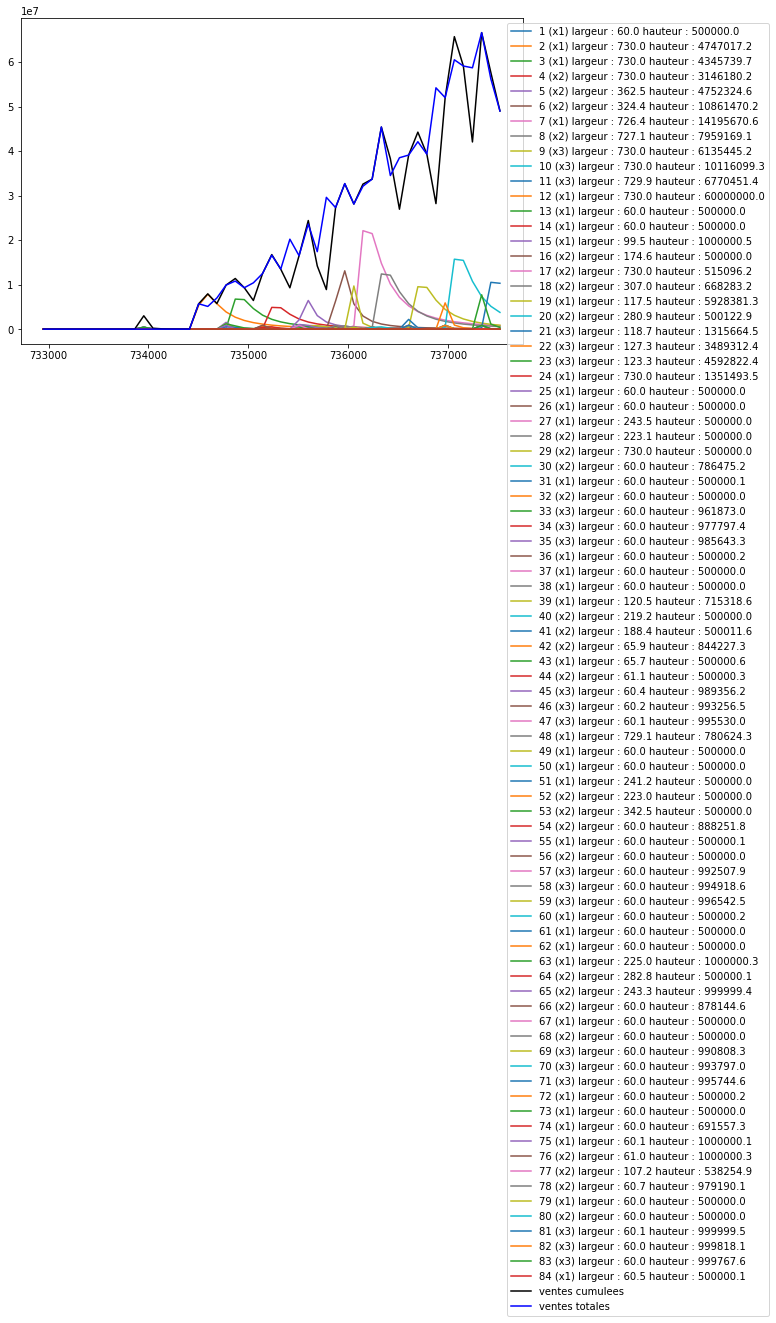

115103186.75748578


In [64]:
touteslesmarqueschiffrees = ["Apple", "Samsung", "Xiaomi", "Oppo", "Vivo", "Sony", "Huawei"]
def obj(X):
    global dates, args, trimestre, ventes_totales 
    return objectif(X, args, [v for v in ventes_totales], [t for t in trimestre])

for marque in touteslesmarqueschiffrees:
    agregat_modeles = dates.loc[lambda df: dates['marque'] == marque, :].groupby('date').apply(lambda x: ' ,'.join(x.modèle))
    ventes_totales = [0 if v != v else float(v.replace(",","."))*1000000  for v in ventes[marque]]
    x0 = [60,1000000]*len(agregat_modeles)
    df_args =  dates.loc[lambda df: dates['marque'] == marque, :].groupby('date').count()["marque"]
    for date in df_args.index:
        if isinstance(date, datetime.date):
            args.append(date.toordinal())
            args.append(df_args[date])
    bnds = (((60, 730),(500000, 60000000))*len(agregat_modeles))
    result = minimize(obj, x0, method='Powell', bounds=bnds)
    montre_solution(result.x, args, ventes_totales, trimestre)
    print(obj(result.x))